In [1]:
import boto3
import pandas as pd
from ete3 import NCBITaxa
import subprocess
import itertools
import os
import s3fs
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from lca_functions import *


In [2]:
s3 = boto3.resource('s3')
client = boto3.client('s3')
bucket_name = "czbiohub-mosquito"
bucket = s3.Bucket(bucket_name)
contig_folders = [x["Prefix"] for x in client.list_objects(Bucket=bucket_name, Prefix="contigs/", Delimiter="/")["CommonPrefixes"]]
contig_quality_folders = [x["Prefix"] for x in client.list_objects(Bucket=bucket_name, Prefix="contig_quality/", Delimiter="/")["CommonPrefixes"]]

ncbi = NCBITaxa()
#ncbi.update_taxonomy_database()




### metadata

In [3]:
metadata = pd.read_csv("../../data/CMS001_CMS002_MergedAnnotations_190325.csv")

### Read counts

In [31]:
read_count_files = [client.list_objects(Bucket=bucket_name, Prefix=x+"Mos/bowtie_csp_counts_1000.txt") \
                   for x in contig_quality_folders]
read_count_files = ["s3://"+bucket_name+"/"+x["Prefix"] for x in read_count_files if "Contents" in x.keys()]
read_counts_csp_1000 = pd.concat([pd.read_csv(x, sep="\t", header=None, names=["query", "read_count"]).\
                                  assign(sample=os.path.split(os.path.split(os.path.split(x)[0])[0])[1]) for x in read_count_files])
filtered_contigs_by_read_count = read_counts_csp_1000[read_counts_csp_1000["read_count"]>2]

### Read in lca results

In [33]:
nt_keys = [x+"blast_lca_nt_filtered.m9" for x in contig_quality_folders if len(list(bucket.objects.filter(Prefix=x+"blast_lca_nt_filtered.m9"))) > 0]
nr_keys = [x+"blast_lca_nr_filtered.m9" for x in contig_quality_folders if len(list(bucket.objects.filter(Prefix=x+"blast_lca_nr_filtered.m9"))) > 0]



In [34]:
nt_tables = [pd.read_csv("s3://"+bucket_name+"/"+x, sep="\t", header=0) for x in nt_keys]

In [35]:
nr_tables = [pd.read_csv("s3://"+bucket_name+"/"+x, sep="\t", header=0) for x in nr_keys]

In [36]:
nt_table_all = pd.concat(nt_tables)
nr_table_all = pd.concat(nr_tables)
#nt_table_all = nt_table_all[(nt_table_all["identity"]>80) & (nt_table_all["align_length"]>300)]
#nr_table_all = nr_table_all[(nr_table_all["identity"]>80) & (nr_table_all["align_length"]>300)]
full_table = pd.concat([nt_table_all, nr_table_all])
full_table = full_table.assign(lineage=[ncbi.get_lineage(x) for x in full_table["taxid"].tolist()])
full_table = full_table.assign(sci_name=[ncbi.get_taxid_translator([x])[x] for x in full_table["taxid"].tolist()])
full_table = full_table.assign(common_name=[ncbi.get_common_names([x])[x] if len(ncbi.get_common_names([x])) > 0 else None for x in full_table["taxid"].tolist()])
full_table = full_table.assign(qlength=full_table["query"].apply(lambda x: int(x.split('_')[3])))
full_table["align_prop"] = abs(full_table["qstart"]-full_table["qend"])/full_table["qlength"]
full_table = pd.merge(full_table, read_counts_csp_1000, on=["query", "sample"], how="left")
full_table = pd.merge(full_table, metadata, left_on="sample", right_on="NewIDseqName", how="left")
full_table = full_table[full_table["read_count"]>2]


/Users/lucy.li/anaconda3/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 1415176 was translated into 2587831
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/lucy.li/anaconda3/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 2267872 was translated into 1653778
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/lucy.li/anaconda3/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 6915 was translated into 2585209
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/lucy.li/anaconda3/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 2109339 was translated into 231269
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


In [37]:
full_table.to_csv("../../data/full_lca_results.txt", sep="\t", index=False)

## Viruses

In [38]:
viral_contigs = filter_by_lineage(full_table[full_table["blast_type"]=="nr"], "taxid", "Viruses")
viral_contigs = viral_contigs[(viral_contigs["read_count"]>2)]


In [39]:
viral_contigs.to_csv("../../data/viral_contigs.txt", sep="\t", index=False)

In [40]:
viral_contigs_summary = viral_contigs.groupby(["sci_name"])["read_count"].describe().sort_values(by=["count"])
viral_contigs_summary

,count,mean,std,min,25%,50%,75%,max
sci_name,,,,,,,,
Acanthocystis turfacea Chlorella virus Br0604L,1.0,4.000000,NaN,4.0,4.0,4.0,4.0,4.0
Culex originated Tymoviridae-like virus,1.0,886.000000,NaN,886.0,886.0,886.0,886.0,886.0
Culex-associated Tombus-like virus,1.0,4.000000,NaN,4.0,4.0,4.0,4.0,4.0
Cumbaru virus,1.0,22.000000,NaN,22.0,22.0,22.0,22.0,22.0
Enterobacteria phage JP501,1.0,244.000000,NaN,244.0,244.0,244.0,244.0,244.0
Hubei diptera virus 17,1.0,4.000000,NaN,4.0,4.0,4.0,4.0,4.0
La Jolla virus,1.0,4.000000,NaN,4.0,4.0,4.0,4.0,4.0
Merida virus,1.0,4.000000,NaN,4.0,4.0,4.0,4.0,4.0
Nilaparvata lugens honeydew virus-3,1.0,128.000000,NaN,128.0,128.0,128.0,128.0,128.0


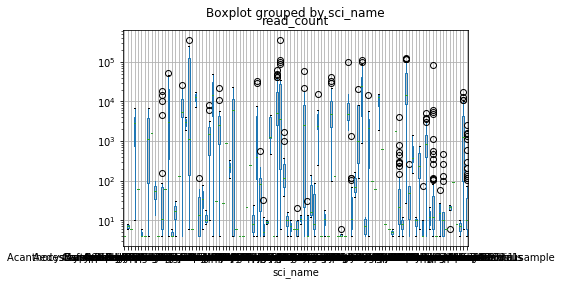

In [41]:
plt = viral_contigs.boxplot(column=["read_count"], by="sci_name")
plt.set_yscale("log")

## Bacteria

In [42]:
bacterial_contigs = filter_by_lineage(full_table[full_table["blast_type"]=="nt"], "taxid", "Bacteria")
bacterial_contigs = bacterial_contigs[(bacterial_contigs["read_count"]>2)]



In [43]:
bacterial_contigs.to_csv("../../data/bacterial_contigs.txt", sep="\t", index=False)

In [44]:
bacterial_contigs["sci_name"].unique()

array(['Candidatus Borrelia tachyglossi', 'Borrelia turcica IST7',
       'Sulfurospirillum sp. UCH001', 'Providencia stuartii MRSN 2154',
       'Halanaerobium hydrogeniformans',
       'Sulfuritalea hydrogenivorans sk43H', 'Anoxybacter fermentans',
       'Shewanella psychrophila', 'Campylobacter lari RM2100',
       'Pelosinus fermentans JBW45', 'Spironema culicis',
       'Providencia sp. WCHPr000369', 'Maribacter sp. MJ134',
       'Winogradskyella sp. J14-2', 'Halobacteroides halobius DSM 5150',
       'Streptobacillus moniliformis DSM 12112',
       'Borrelia coriaceae Co53', 'Sulfuriflexus mobilis',
       'Acinetobacter baumannii SDF', 'Frischella perrara',
       'Olsenella umbonata', 'Bradyrhizobium lablabi',
       'Fuerstia marisgermanicae', 'Phycicoccus dokdonensis',
       'Jeongeupia sp. USM3', 'Flavobacterium frigidimaris',
       'Streptomyces luteoverticillatus', 'Kribbella flavida DSM 17836',
       'Kitasatospora sp. MMS16-BH015', 'Sorangium cellulosum So0157-2',
 

## Fungus

In [45]:
fungal_contigs = filter_by_lineage(full_table[full_table["blast_type"]=="nt"], "taxid", "Fungi")
fungal_contigs = fungal_contigs[fungal_contigs["read_count"]>2]
fungal_contigs.to_csv("../../data/fungal_contigs.txt", sep="\t", index=False)


In [46]:
fungal_contigs["sci_name"].unique()

array(['Bipolaris sorokiniana ND90Pr', 'Xanthophyllomyces dendrorhous',
       'Thermothelomyces thermophilus ATCC 42464',
       'Aspergillus ibericus CBS 121593',
       'Eremothecium cymbalariae DBVPG#7215', 'Ustilago bromivora',
       'Cyberlindnera jadinii NRRL Y-1542', 'Schizophyllum commune H4-8',
       'Metschnikowia aff. pulcherrima', 'Pseudozyma hubeiensis SY62',
       'Pochonia chlamydosporia 170',
       'Schizosaccharomyces octosporus yFS286',
       'Anthracocystis flocculosa PF-1', 'Postia placenta MAD-698-R-SB12',
       'Rhinocladiella mackenziei CBS 650.93', 'Kockovaella imperatae',
       'Phycomyces blakesleeanus NRRL 1555(-)', 'Exophiala lecanii-corni',
       'Kwoniella pini CBS 10737', 'Neurospora tetrasperma FGSC 2508',
       'Thielavia terrestris NRRL 8126', 'Candida viswanathii',
       'Paraphaeosphaeria sporulosa', 'Malassezia globosa CBS 7966',
       'Diplodia corticola', 'Cyberlindnera fabianii',
       'Sordaria macrospora k-hell', 'Rasamsonia emerso

## Bloodmeal

In [47]:
chordate_contigs = filter_by_lineage(full_table[full_table["blast_type"]=="nt"], "taxid", "Chordata")
chordate_contigs = chordate_contigs[(chordate_contigs["read_count"]>2)]

chordate_contigs.to_csv("../../data/bloodmeal_contigs.txt", sep="\t", index=False)



In [48]:
chordate_contigs[["sci_name", "common_name", "sample", "bitscore"]]

,sci_name,common_name,sample,bitscore
9,Bos mutus,wild yak,CMS001_001_Ra_S1,52.8
13,Pygocentrus nattereri,red-bellied piranha,CMS001_001_Ra_S1,52.8
37,Bos mutus,wild yak,CMS001_001_Ra_S1,261.0
45,Gouania willdenowi,blunt-snouted clingfish,CMS001_001_Ra_S1,54.7
77,Betta splendens,Siamese fighting fish,CMS001_001_Ra_S1,54.7
100,Ovis canadensis canadensis,None,CMS001_001_Ra_S1,54.7
119,Ovis canadensis canadensis,None,CMS001_001_Ra_S1,52.8
120,Ovis canadensis canadensis,None,CMS001_001_Ra_S1,322.0
155,Denticeps clupeoides,denticle herring,CMS001_001_Ra_S1,52.8
185,Labrus bergylta,ballan wrasse,CMS001_001_Ra_S1,56.5
